Train: (60000, 1, 28, 28) Test: (10000, 1, 28, 28)
Epoch 1 step 200 | loss 0.4456
Epoch 1 step 400 | loss 0.3853
Epoch 01 | train loss 0.3025 | test loss 0.2695 | train acc 92.19% | test acc 92.85% | time 26.5s
Epoch 2 step 200 | loss 0.2575
Epoch 2 step 400 | loss 0.1920
Epoch 02 | train loss 0.2386 | test loss 0.2073 | train acc 93.55% | test acc 94.14% | time 25.7s
Epoch 3 step 200 | loss 0.2855
Epoch 3 step 400 | loss 0.1760
Epoch 03 | train loss 0.2474 | test loss 0.2155 | train acc 93.43% | test acc 94.05% | time 26.1s
Epoch 4 step 200 | loss 0.2588
Epoch 4 step 400 | loss 0.2217
Epoch 04 | train loss 0.2066 | test loss 0.1805 | train acc 94.61% | test acc 95.09% | time 26.0s
Epoch 5 step 200 | loss 0.1924
Epoch 5 step 400 | loss 0.2632
Epoch 05 | train loss 0.2084 | test loss 0.1811 | train acc 94.26% | test acc 94.94% | time 25.8s
Epoch 6 step 200 | loss 0.1198
Epoch 6 step 400 | loss 0.1978
Epoch 06 | train loss 0.1837 | test loss 0.1608 | train acc 94.85% | test acc 95.30% | 

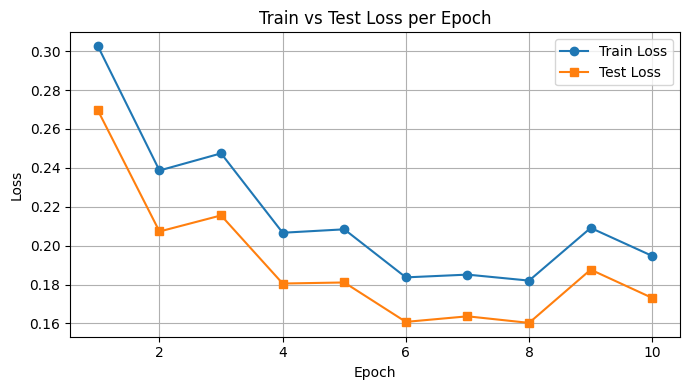

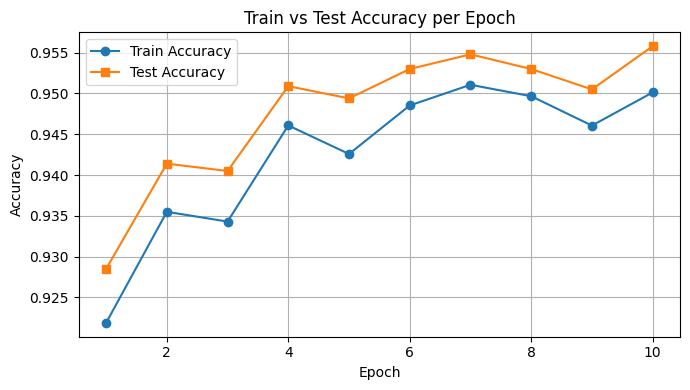


Showing fixed examples (0,123,999):


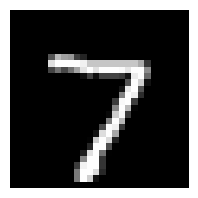

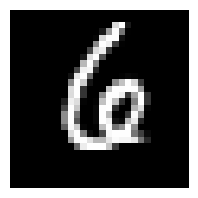

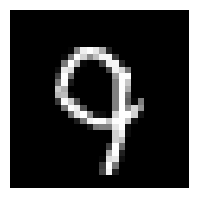


Random grid of 10 samples:


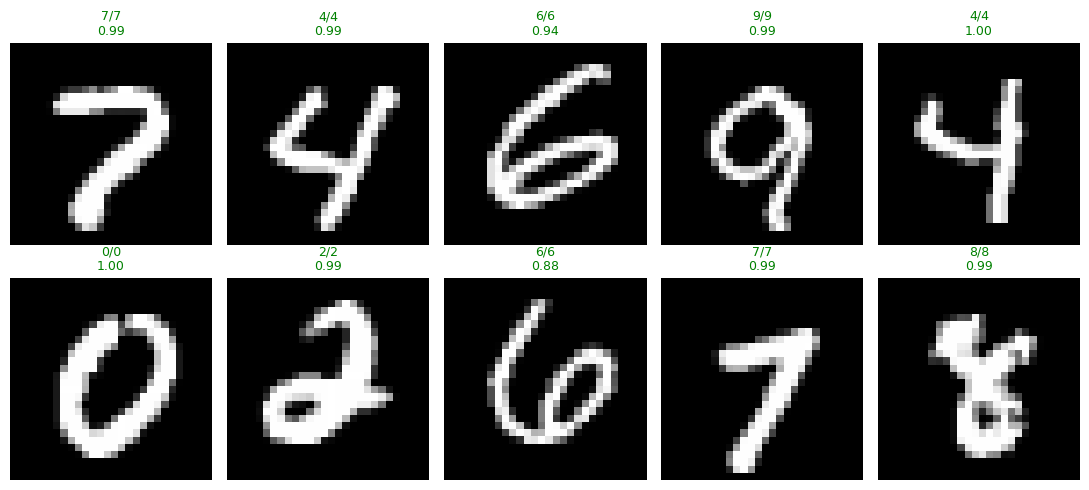

In [5]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data 
def load_csv(path):
    df = pd.read_csv(path)
    data = df.values.astype(np.float32)
    y = data[:, 0].astype(np.int64)
    X = data[:, 1:] / 255.0
    X = X.reshape(-1, 1, 28, 28)
    return X, y

def one_hot(y, C=10):
    oh = np.zeros((y.size, C), dtype=np.float32)
    oh[np.arange(y.size), y] = 1.0
    return oh

# im2col / col2im 
def im2col(X, kH, kW, stride=1, pad=0):
    N, C, H, W = X.shape
    Hpad, Wpad = H + 2*pad, W + 2*pad
    Xp = np.zeros((N, C, Hpad, Wpad), dtype=X.dtype)
    Xp[:, :, pad:pad+H, pad:pad+W] = X
    out_h = (Hpad - kH) // stride + 1
    out_w = (Wpad - kW) // stride + 1
    cols = np.zeros((N*out_h*out_w, C*kH*kW), dtype=X.dtype)
    idx = 0
    for i in range(0, Hpad - kH + 1, stride):
        for j in range(0, Wpad - kW + 1, stride):
            patch = Xp[:, :, i:i+kH, j:j+kW].reshape(N, -1)
            cols[idx*N:(idx+1)*N, :] = patch
            idx += 1
    return cols, out_h, out_w

def col2im(cols, X_shape, kH, kW, stride=1, pad=0, out_h=None, out_w=None):
    N, C, H, W = X_shape
    Hpad, Wpad = H + 2*pad, W + 2*pad
    Xp = np.zeros((N, C, Hpad, Wpad), dtype=cols.dtype)
    idx = 0
    for i in range(0, Hpad - kH + 1, stride):
        for j in range(0, Wpad - kW + 1, stride):
            patch = cols[idx*N:(idx+1)*N, :].reshape(N, C, kH, kW)
            Xp[:, :, i:i+kH, j:j+kW] += patch
            idx += 1
    return Xp[:, :, pad:pad+H, pad:pad+W]

#Layers
class Conv2D:
    def __init__(self, in_ch, out_ch, ksize, stride=1, pad=0):
        self.kH = self.kW = ksize
        self.stride = stride
        self.pad = pad
        scale = math.sqrt(2.0 / (in_ch * ksize * ksize))
        self.W = (np.random.randn(out_ch, in_ch, ksize, ksize).astype(np.float32) * scale)
        self.b = np.zeros((out_ch,), dtype=np.float32)

    def forward(self, X):
        self.X = X
        self.cols, self.out_h, self.out_w = im2col(X, self.kH, self.kW, self.stride, self.pad)
        W_col = self.W.reshape(self.W.shape[0], -1)
        out2d = (self.cols @ W_col.T) + self.b
        out = out2d.reshape(self.out_h*self.out_w, -1, out2d.shape[1])
        out = out.transpose(1,2,0).reshape(X.shape[0], self.W.shape[0], self.out_h, self.out_w)
        return out

    def backward(self, dY, lr):
        dY2d = dY.transpose(0,2,3,1).reshape(-1, self.W.shape[0])
        W_col = self.W.reshape(self.W.shape[0], -1)
        dW = dY2d.T @ self.cols
        db = dY2d.sum(axis=0)
        dcols = dY2d @ W_col
        dX = col2im(dcols, self.X.shape, self.kH, self.kW, self.stride, self.pad,
                    out_h=self.out_h, out_w=self.out_w)
        self.W -= lr * dW.reshape(self.W.shape)
        self.b -= lr * db
        return dX

class ReLU:
    def forward(self, X):
        self.mask = X > 0
        return X * self.mask
    def backward(self, dY, lr):
        return dY * self.mask

class MaxPool2:
    def forward(self, X):
        N, C, H, W = X.shape
        pad_h = (2 - (H % 2)) % 2
        pad_w = (2 - (W % 2)) % 2
        if pad_h or pad_w:
            Xp = np.pad(X, ((0,0),(0,0),(0,pad_h),(0,pad_w)), mode='constant', constant_values=0)
        else:
            Xp = X
        self.pad_h, self.pad_w = pad_h, pad_w
        Hp, Wp = Xp.shape[2], Xp.shape[3]
        H2, W2 = Hp//2, Wp//2
        self.Xresh = Xp.reshape(N, C, H2, 2, W2, 2)
        self.out = self.Xresh.max(axis=(3,5))
        return self.out

    def backward(self, dY, lr):
        pooled = self.out[..., None, :, None]
        mask = (self.Xresh == pooled)
        counts = mask.sum(axis=(3,5), keepdims=True)
        dXresh = mask * (dY[..., None, :, None] / np.maximum(counts, 1))
        dXp = dXresh.reshape(self.Xresh.shape[0], self.Xresh.shape[1],
                             self.Xresh.shape[2]*2, self.Xresh.shape[4]*2)
        if self.pad_h or self.pad_w:
            dX = dXp[:, :, :dXp.shape[2]-self.pad_h, :dXp.shape[3]-self.pad_w]
        else:
            dX = dXp
        return dX

class Flatten:
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(X.shape[0], -1)
    def backward(self, dY, lr):
        return dY.reshape(self.shape)

class Dense:
    def __init__(self, in_dim, out_dim):
        scale = math.sqrt(2.0 / in_dim)
        self.W = (np.random.randn(in_dim, out_dim).astype(np.float32) * scale)
        self.b = np.zeros((out_dim,), dtype=np.float32)
    def forward(self, X):
        self.X = X
        return X @ self.W + self.b
    def backward(self, dY, lr):
        dW = self.X.T @ dY
        db = dY.sum(axis=0)
        dX = dY @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dX

class SoftmaxCE:
    def forward(self, logits, y_onehot):
        ex = np.exp(logits - logits.max(axis=1, keepdims=True))
        self.p = ex / ex.sum(axis=1, keepdims=True)
        self.y = y_onehot
        loss = -np.log((self.p * self.y).sum(axis=1) + 1e-12).mean()
        return loss
    def backward(self):
        N = self.y.shape[0]
        return (self.p - self.y) / N

# Model
class CNN3:
    def __init__(self):
        self.c1 = Conv2D(1, 8, 3, stride=1, pad=0)
        self.r1 = ReLU(); self.p1 = MaxPool2()
        self.c2 = Conv2D(8, 16, 3, stride=1, pad=0)
        self.r2 = ReLU()
        self.c3 = Conv2D(16, 32, 3, stride=1, pad=0)
        self.r3 = ReLU(); self.p2 = MaxPool2()
        self.flat = Flatten()
        self.fc = None
        self.crit = SoftmaxCE()

    def forward(self, X, y_onehot=None):
        x = self.c1.forward(X); x = self.r1.forward(x); x = self.p1.forward(x)
        x = self.c2.forward(x); x = self.r2.forward(x)
        x = self.c3.forward(x); x = self.r3.forward(x); x = self.p2.forward(x)
        x = self.flat.forward(x)
        if self.fc is None:
            self.fc = Dense(x.shape[1], 10)
        logits = self.fc.forward(x)
        if y_onehot is None:
            return logits
        loss = self.crit.forward(logits, y_onehot)
        return loss, logits

    def backward(self, lr):
        d = self.crit.backward()
        d = self.fc.backward(d, lr)
        d = self.flat.backward(d, lr)
        d = self.p2.backward(d, lr)
        d = self.r3.backward(d, lr)
        d = self.c3.backward(d, lr)
        d = self.r2.backward(d, lr)
        d = self.c2.backward(d, lr)
        d = self.p1.backward(d, lr)
        d = self.r1.backward(d, lr)
        _ = self.c1.backward(d, lr)

# ------------------- Helpers -------------------
def iterate_batches(X, y, batch, shuffle=True, seed=None):
    N = len(X)
    idx = np.arange(N)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for i in range(0, N, batch):
        j = idx[i:i+batch]
        yield X[j], y[j]

def softmax(logits):
    ex = np.exp(logits - logits.max(axis=1, keepdims=True))
    return ex / ex.sum(axis=1, keepdims=True)

def accuracy_and_loss(net, X, y, y_onehot):
    losses, preds = [], []
    for i in range(0, len(X), 4096):
        Xb = X[i:i+4096]
        yb = y[i:i+4096]
        yh = y_onehot[i:i+4096]
        loss, logits = net.forward(Xb, yh)
        losses.append(loss)
        preds.append(logits.argmax(axis=1))
    preds = np.concatenate(preds)
    acc = (preds == y).mean()
    return float(np.mean(losses)), acc

def per_digit_accuracy(net, X, y):
    preds = []
    for i in range(0, len(X), 4096):
        preds.append(net.forward(X[i:i+4096]).argmax(axis=1))
    preds = np.concatenate(preds)
    per_digit = {d: ((preds[y==d]==d).mean() if (y==d).sum()>0 else np.nan) for d in range(10)}
    return per_digit

def show_image_preds(net, X, y):
    for idx in (0,123,999):
        logits = net.forward(X[idx:idx+1])
        p = softmax(logits)[0]
        pred, conf, true = int(p.argmax()), float(p.max()), int(y[idx])
        plt.figure(figsize=(2.3,2.4))
        plt.imshow(X[idx,0], cmap='gray'); plt.axis('off')
        plt.show()

def show_random_grid(net, X, y, n=10, seed=5):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(X), size=n, replace=False)
    rows, cols = 2,5
    plt.figure(figsize=(2.2*cols,2.5*rows))
    for i, idx in enumerate(idxs,1):
        logits = net.forward(X[idx:idx+1])
        p = softmax(logits)[0]
        pred, conf, true = int(p.argmax()), float(p.max()), int(y[idx])
        plt.subplot(rows,cols,i)
        plt.imshow(X[idx,0], cmap='gray'); plt.axis('off')
        plt.title(f"{pred}/{true}\n{conf:.2f}", color=('green' if pred==true else 'red'), fontsize=9)
    plt.tight_layout(); plt.show()

# Main
def main():
    Xtr,ytr = load_csv("mnist_train.csv")
    Xte,yte = load_csv("mnist_test.csv")
    ytr_oh = one_hot(ytr)
    yte_oh = one_hot(yte)

    LR=5e-2; BATCH=128; EPOCHS=10; PRINT_EVERY=200

    net = CNN3()
    print("Train:", Xtr.shape, "Test:", Xte.shape)

    train_losses, test_losses, train_accs, test_accs = [],[],[],[]

    for ep in range(1,EPOCHS+1):
        t0=time.time(); losses=[]; it=0
        for xb,yb in iterate_batches(Xtr,ytr_oh,BATCH,shuffle=True,seed=ep):
            it+=1
            loss,_=net.forward(xb,yb)
            net.backward(LR)
            losses.append(loss)
            if it%PRINT_EVERY==0:
                print(f"Epoch {ep} step {it} | loss {loss:.4f}")
        mean_train_loss=float(np.mean(losses))
        tr_loss,tr_acc=accuracy_and_loss(net,Xtr,ytr,ytr_oh)
        te_loss,te_acc=accuracy_and_loss(net,Xte,yte,yte_oh)
        train_losses.append(tr_loss); test_losses.append(te_loss)
        train_accs.append(tr_acc); test_accs.append(te_acc)
        print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} | test loss {te_loss:.4f} "
              f"| train acc {tr_acc*100:.2f}% | test acc {te_acc*100:.2f}% | time {time.time()-t0:.1f}s")

    print("\nPer-digit accuracy on test set:")
    pd_acc=per_digit_accuracy(net,Xte,yte)
    for d,v in pd_acc.items(): print(f"Digit {d}: {v*100:.2f}%")

    # Train vs Test Loss
    epochs=np.arange(1,EPOCHS+1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs,train_losses,'o-',label='Train Loss')
    plt.plot(epochs,test_losses,'s-',label='Test Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Train vs Test Loss per Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    #Train vs Test Accuracy
    plt.figure(figsize=(7,4))
    plt.plot(epochs,train_accs,'o-',label='Train Accuracy')
    plt.plot(epochs,test_accs,'s-',label='Test Accuracy')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy per Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    print("\nShowing fixed examples (0,123,999):")
    show_image_preds(net,Xte,yte)
    print("\nRandom grid of 10 samples:")
    show_random_grid(net,Xte,yte)
if __name__=="__main__":
    main()